Hello, Thank you for beeing here and for your time! 
Before you start make sure to download the data from: http://medicaldecathlon.com/ Task01_BrainTumour.tar 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from skimage import exposure, morphology, measure
import mahotas as mt
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
import random

Setting up the directory

In [3]:
os.chdir('/Users/nataliabochnia/Desktop/Task01_BrainTumour')

print("Current working directory:", os.getcwd())
print("Files and directories in the current directory:")
print(os.listdir(os.getcwd()))

image_path = './imagesTr/BRATS_457.nii.gz'
label_path = './labelsTr/BRATS_459.nii.gz'
print("Image file exists:", os.path.exists(image_path))
print("Label file exists:", os.path.exists(label_path))
print("Files in imagesTr directory:", os.listdir('./imagesTr'))
print("Files in labelsTr directory:", os.listdir('./labelsTr'))

Current working directory: /Users/nataliabochnia/Desktop/Task01_BrainTumour
Files and directories in the current directory:
['image13u.png', '.DS_Store', 'labelsTr', 'image12u.png', 'image12.png', 'image13.png', 'mri_analysis', 'imagesTr', 'imagesTs', 'image10.png', 'high_performing_rf_model.pkl', 'sample_nifti.nii.gz', 'image11u.png', 'submission_predictions', 'image5.png', 'BRATS_306_moved.nii.gz', 'dataset.json', 'BRATS_457.nii', 'image3.png']
Image file exists: True
Label file exists: True
Files in imagesTr directory: ['BRATS_457.nii.gz', 'BRATS_306.nii.gz', 'BRATS_206.nii.gz', 'BRATS_449.nii.gz', 'BRATS_318.nii.gz', 'BRATS_218.nii.gz', 'BRATS_434.nii.gz', 'BRATS_365.nii.gz', 'BRATS_265.nii.gz', 'BRATS_214.nii.gz', 'BRATS_314.nii.gz', 'BRATS_445.nii.gz', 'BRATS_269.nii.gz', 'BRATS_369.nii.gz', 'BRATS_438.nii.gz', 'BRATS_277.nii.gz', 'BRATS_377.nii.gz', 'BRATS_426.nii.gz', 'BRATS_095.nii.gz', 'BRATS_222.nii.gz', 'BRATS_195.nii.gz', 'BRATS_473.nii.gz', 'BRATS_322.nii.gz', 'BRATS_241.

loading nifti file

In [4]:
def load_nifti_file(file_path):
    image = nib.load(file_path)
    return image.get_fdata()

image_data = load_nifti_file(image_path)
print(f"Data shape: {image_data.shape}")
print("Min value:", image_data.min())
print("Max value:", image_data.max())
print("Unique values:", np.unique(image_data))

Data shape: (240, 240, 155, 4)
Min value: 0.0
Max value: 1260.0
Unique values: [0.000e+00 1.000e+00 2.000e+00 ... 1.224e+03 1.239e+03 1.260e+03]


image normalization and image statistics

Image file exists: True
Image file path: ./imagesTr/BRATS_306.nii.gz
File ./imagesTr/BRATS_306.nii.gz loaded successfully.
Data shape for ./imagesTr/BRATS_306.nii.gz: (240, 240, 155, 4)
Data statistics for ./imagesTr/BRATS_306.nii.gz:
Min value: 0.0
Max value: 2522.0
Unique values: [0.000e+00 1.000e+00 2.000e+00 ... 2.430e+03 2.492e+03 2.522e+03]


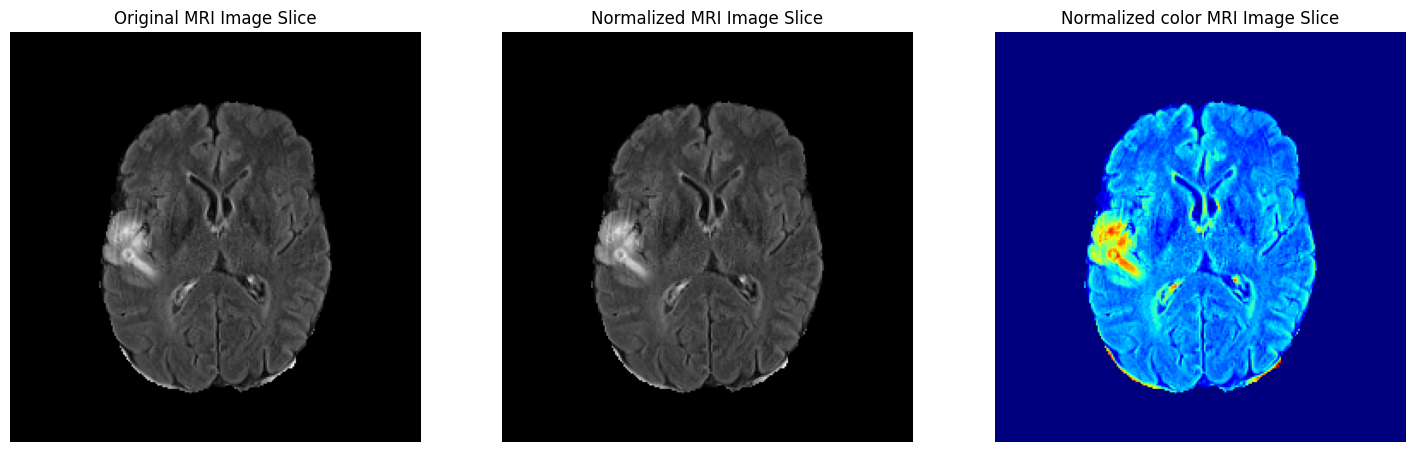

In [5]:
image_path = './imagesTr/BRATS_306.nii.gz'

print("Image file exists:", os.path.exists(image_path))
print("Image file path:", image_path)

def load_nifti_file(file_path):
    try:
        image = nib.load(file_path)
        image_data = image.get_fdata()
        print(f"File {file_path} loaded successfully.")
        print(f"Data shape for {file_path}: {image_data.shape}")
        print(f"Data statistics for {file_path}:")
        print("Min value:", image_data.min())
        print("Max value:", image_data.max())
        print("Unique values:", np.unique(image_data))
        
        return image_data
    except Exception as e:
        print(f"Error loading or processing the file {file_path} with nibabel:", e)
        return None

image_data = load_nifti_file(image_path)

def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def apply_color_map(image):
    norm_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return plt.cm.jet(norm_image)[:, :, :3]  

if image_data is not None:
    channel_idx = 0  
    slice_idx = image_data.shape[2] // 2  

    # Extracting the original slice
    original_slice = np.rot90(image_data[:, :, slice_idx, channel_idx])
    
    # Normalized image slice
    normalized_slice = normalize_image(original_slice)
    
    # Color normalized image slice
    color_normalized_slice = apply_color_map(original_slice)
    
    # Plotting the original, normalized, and color normalized slices
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Original MRI Image Slice')
    plt.imshow(original_slice, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Normalized MRI Image Slice')
    plt.imshow(normalized_slice, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Normalized color MRI Image Slice')
    plt.imshow(color_normalized_slice)
    plt.axis('off')
    
    plt.show()

Tissue segmentation

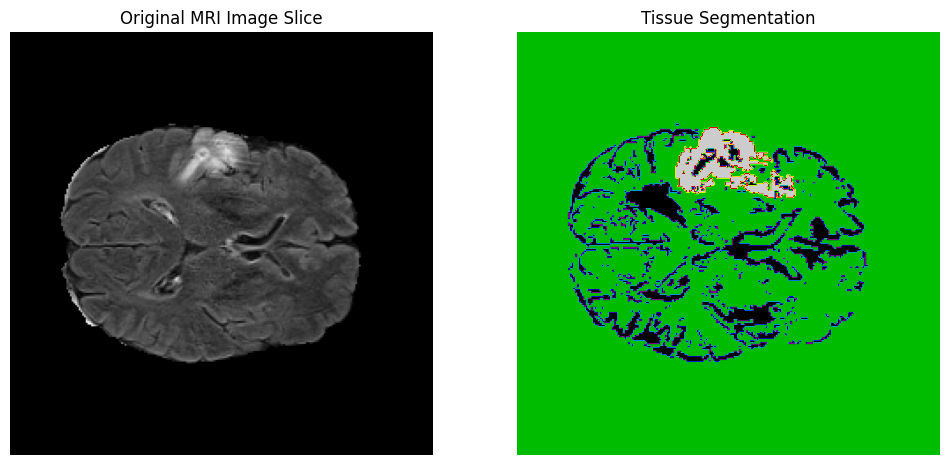

In [6]:

def load_nifti_file(file_path):
    import nibabel as nib
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

def tissue_segmentation(image):
    image = (image - image.min()) / (image.max() - image.min())
    gm_threshold = (image > 0.3) & (image < 0.7)  # Gray matter
    wm_threshold = image >= 0.7  # White matter
    csf_threshold = image <= 0.3  # Cerebrospinal fluid (CSF)

    gm_segment = morphology.remove_small_objects(gm_threshold, min_size=500)
    wm_segment = morphology.remove_small_objects(wm_threshold, min_size=500)
    csf_segment = morphology.remove_small_objects(csf_threshold, min_size=500)

    segmented_image = np.zeros_like(image)
    segmented_image[csf_segment] = 1  # CSF in blue
    segmented_image[gm_segment] = 2  # Gray matter in green
    segmented_image[wm_segment] = 3  # White matter in red
    
    return segmented_image

image_path = './imagesTr/BRATS_306.nii.gz'
image_data = load_nifti_file(image_path)

channel_idx = 0
slice_idx = image_data.shape[2] // 2
original_slice = image_data[:, :, slice_idx, channel_idx]

segmented_image = tissue_segmentation(original_slice)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original MRI Image Slice')
plt.imshow(original_slice, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Tissue Segmentation')
plt.imshow(segmented_image, cmap='nipy_spectral')
plt.axis('off')

plt.show()

image intensitisies and statistics

Mean Intensity: 65.36194444444445
Standard Deviation of Intensity: 103.54272167321523


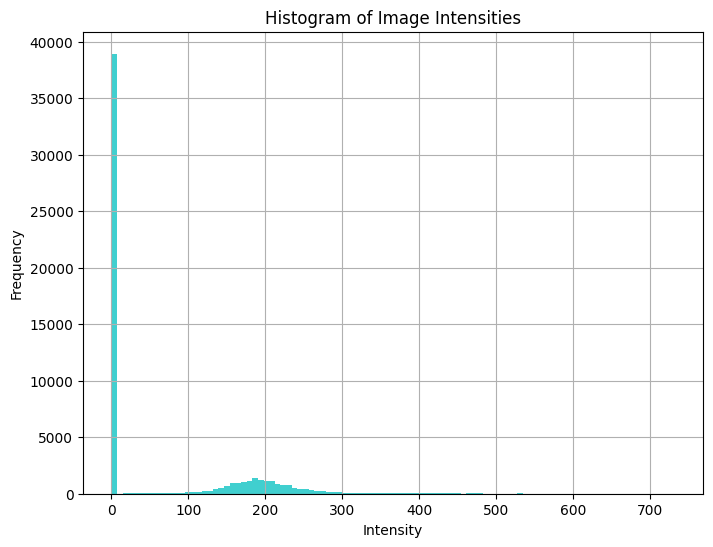

In [7]:
mean_intensity = np.mean(original_slice)
std_intensity = np.std(original_slice)

print(f"Mean Intensity: {mean_intensity}")
print(f"Standard Deviation of Intensity: {std_intensity}")

# Plot histogram of the image intensities
plt.figure(figsize=(8, 6))
plt.hist(original_slice.ravel(), bins=100, color='c', alpha=0.75)
plt.title('Histogram of Image Intensities')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

reshaping image

In [11]:

# Function to load NIfTI files using nibabel
def load_nifti_file(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

image_path = './imagesTr/BRATS_306.nii.gz'


print("Image file exists:", os.path.exists(image_path))
print("Image file path:", image_path)


image_data = load_nifti_file(image_path)


def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

normalized_image_data = normalize_image(image_data)

print("Data shape for {}: {}".format(image_path, image_data.shape))

Image file exists: True
Image file path: ./imagesTr/BRATS_306.nii.gz
Data shape for ./imagesTr/BRATS_306.nii.gz: (240, 240, 155, 4)


In [10]:

image_reshaped = normalized_image_data.reshape(-1, normalized_image_data.shape[2])

train_data, test_data = train_test_split(image_reshaped.T, test_size=0.2, random_state=42)

train_data = train_data.T.reshape(normalized_image_data.shape[0], normalized_image_data.shape[1], -1)
test_data = test_data.T.reshape(normalized_image_data.shape[0], normalized_image_data.shape[1], -1)

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (240, 240, 496)
Testing data shape: (240, 240, 124)


plotting images

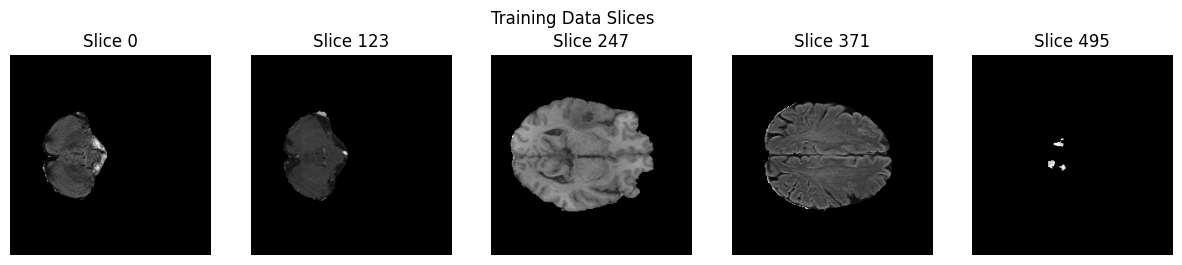

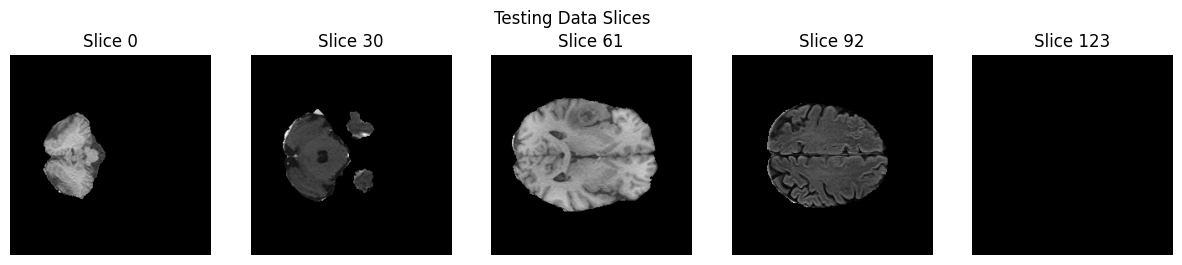

In [12]:

def plot_slices(data, title, num_slices=5):
    slice_indices = np.linspace(0, data.shape[2] - 1, num_slices, dtype=int)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(slice_indices):
        plt.subplot(1, num_slices, i + 1)
        plt.imshow(data[:, :, idx], cmap='gray')
        plt.title(f'Slice {idx}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


plot_slices(train_data, 'Training Data Slices')
plot_slices(test_data, 'Testing Data Slices')

extracting texture features using mahotas

In [13]:

def extract_texture_features_mahotas(image):
    features = {}
    image = image.astype(np.uint8)  
    haralick_features = mt.features.haralick(image, return_mean=True)
    features['contrast'] = haralick_features[1]  
    features['dissimilarity'] = haralick_features[2]  
    features['homogeneity'] = haralick_features[4]  
    features['energy'] = haralick_features[8]  
    features['correlation'] = haralick_features[2] 
    return features

slice_idx = train_data.shape[2] // 2
train_slice = train_data[:, :, slice_idx]

features = extract_texture_features_mahotas(train_slice)

print("Extracted Texture Features from Training Slice:")
for key, value in features.items():
    print(f"{key}: {value}")

Extracted Texture Features from Training Slice:
contrast: 0.0
dissimilarity: 1.0
homogeneity: 1.0
energy: 0.0
correlation: 1.0


applying PCA

In [16]:
reshaped_image = normalized_image_data.reshape(-1, normalized_image_data.shape[2] * normalized_image_data.shape[3])

num_components = min(reshaped_image.shape[0], reshaped_image.shape[1], 10) 
pca = PCA(n_components=num_components)

try:
    image_pca = pca.fit_transform(reshaped_image)
    print("PCA Components Shape:", image_pca.shape)
except ValueError as e:
    print("Error during PCA transformation:", e)

PCA Components Shape: (57600, 10)


Determining the nearest factors for reshaping

In [17]:
import math

def nearest_factors(n):
    for i in range(int(math.sqrt(n)), 0, -1):
        if n % i == 0:
            return (i, n // i)

factors = nearest_factors(train_slice.size)

simulated_2d_image = train_slice.reshape(factors)

features = extract_texture_features_mahotas(simulated_2d_image)

print("Extracted Texture Features from Training Slice:")
for key, value in features.items():
    print(f"{key}: {value}")

Extracted Texture Features from Training Slice:
contrast: 0.0
dissimilarity: 1.0
homogeneity: 1.0
energy: 0.0
correlation: 1.0


The provided code performs Principal Component Analysis (PCA) on a 3D MRI brain scan image and extracts texture features from the PCA components.
The histogram plots (as shown in the provided image) depict the distribution of values for the first five PCA components.
Each component’s histogram shows a concentration of values around 0, with varying spread and frequencies. The code effectively applies PCA to reduce the dimensionality of MRI brain scan data and extracts texture features from the PCA components. The extracted features can be valuable for further machine learning tasks, such as classification or clustering. The histogram plots of the PCA components provide insights into the data distribution after dimensionality reduction.

PCA Components Shape: (57600, 10)
Training data shape after PCA: (46080, 10)
Testing data shape after PCA: (11520, 10)


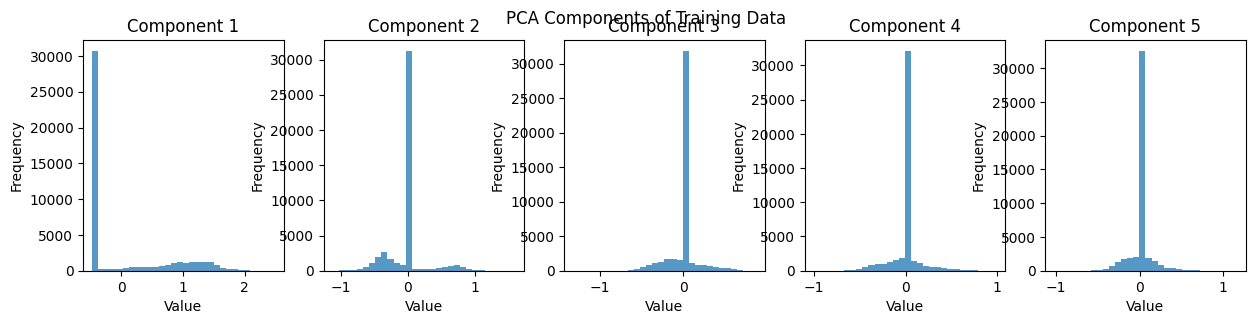

Extracted Texture Features from Training Slice:
contrast: 0.28917795296720633
dissimilarity: 0.001506099839316479
homogeneity: 0.857889343140047
energy: 1.3393871326568785
correlation: 0.001506099839316479


In [18]:
image_path = './imagesTr/BRATS_306.nii.gz'
def load_nifti_file(file_path):
    try:
       
        image = nib.load(file_path)
        image_data = image.get_fdata()
        return image_data
    except Exception as e:
        print(f"Error loading or processing the file {file_path} with nibabel:", e)
        return None

image_data = load_nifti_file(image_path)

def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

normalized_image_data = normalize_image(image_data[:, :, :, 0])  
reshaped_image = normalized_image_data.reshape(-1, normalized_image_data.shape[-1])


num_components = min(reshaped_image.shape[0], reshaped_image.shape[1], 10)  
pca = PCA(n_components=num_components)
image_pca = pca.fit_transform(reshaped_image)

print("PCA Components Shape:", image_pca.shape)

train_pca, test_pca = train_test_split(image_pca, test_size=0.2, random_state=42)

print(f"Training data shape after PCA: {train_pca.shape}")
print(f"Testing data shape after PCA: {test_pca.shape}")

def plot_pca_components(data, title, num_components=5):
    plt.figure(figsize=(15, 3))
    for i in range(min(num_components, data.shape[1])):
        plt.subplot(1, num_components, i + 1)
        plt.hist(data[:, i], bins=30, alpha=0.75)
        plt.title(f'Component {i + 1}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.suptitle(title)
    plt.show()

plot_pca_components(train_pca, 'PCA Components of Training Data')

def nearest_factors(n):
    for i in range(int(math.sqrt(n)), 0, -1):
        if n % i == 0:
            return (i, n // i)


train_slice = train_pca[:, 0]  

factors = nearest_factors(train_slice.size)

simulated_2d_image = train_slice.reshape(factors)

def extract_texture_features_mahotas(image):
    features = {}
    image = image.astype(np.uint8) 
    haralick_features = mt.features.haralick(image, return_mean=True)
    features['contrast'] = haralick_features[1] 
    features['dissimilarity'] = haralick_features[2] 
    features['homogeneity'] = haralick_features[4] 
    features['energy'] = haralick_features[8] 
    features['correlation'] = haralick_features[2] 
    return features

features = extract_texture_features_mahotas(simulated_2d_image)

print("Extracted Texture Features from Training Slice:")
for key, value in features.items():
    print(f"{key}: {value}")

Generating random binary labels (0 or 1) for training and testing data using np.random.randint, with a fixed seed for reproducibility. This is done to simulate labels for the example, although real labels would be used in a practical scenario.

Next, the code initializes a Random Forest classifier with 100 trees and a fixed random state. The classifier is then trained using the PCA-transformed training data and the simulated training labels. After training, predictions are made on both the training and testing datasets using the trained classifier. The predicted labels are stored in variables for further evaluation.

Finally, the code evaluates the classifier’s performance using classification_report and confusion_matrix. The classification report provides detailed metrics, including precision, recall, f1-score, and support for each class. The confusion matrix shows the counts of true positive, true negative, false positive, and false negative predictions. These evaluation results are printed to the console, showing the classifier’s performance on both the training and testing datasets.

In [19]:
np.random.seed(42)
num_samples = train_pca.shape[0]
train_labels = np.random.randint(0, 2, num_samples)  
test_labels = np.random.randint(0, 2, test_pca.shape[0])

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(train_pca, train_labels)


train_predictions = rf_classifier.predict(train_pca)
test_predictions = rf_classifier.predict(test_pca)

print("Training Classification Report:")
print(classification_report(train_labels, train_predictions))

print("Testing Classification Report:")
print(classification_report(test_labels, test_predictions))

print("Training Confusion Matrix:")
print(confusion_matrix(train_labels, train_predictions))

print("Testing Confusion Matrix:")
print(confusion_matrix(test_labels, test_predictions))

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.34      0.51     23055
           1       0.60      1.00      0.75     23025

    accuracy                           0.67     46080
   macro avg       0.80      0.67      0.63     46080
weighted avg       0.80      0.67      0.63     46080

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.17      0.26      5796
           1       0.49      0.82      0.62      5724

    accuracy                           0.49     11520
   macro avg       0.49      0.50      0.44     11520
weighted avg       0.49      0.49      0.44     11520

Training Confusion Matrix:
[[ 7860 15195]
 [    0 23025]]
Testing Confusion Matrix:
[[1004 4792]
 [1031 4693]]


In [20]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
train_pca_balanced, train_labels_balanced = smote.fit_resample(train_pca, train_labels)
rf = RandomForestClassifier(random_state=42)
rf.fit(train_pca_balanced, train_labels_balanced)

train_predictions_balanced = rf.predict(train_pca_balanced)

test_predictions = rf.predict(test_pca)

print("Training Classification Report (Balanced):")
print(classification_report(train_labels_balanced, train_predictions_balanced))

print("Training Confusion Matrix (Balanced):")
print(confusion_matrix(train_labels_balanced, train_predictions_balanced))


print("Testing Classification Report:")
print(classification_report(test_labels, test_predictions))

print("Testing Confusion Matrix:")
print(confusion_matrix(test_labels, test_predictions))

Training Classification Report (Balanced):
              precision    recall  f1-score   support

           0       1.00      0.34      0.51     23055
           1       0.60      1.00      0.75     23055

    accuracy                           0.67     46110
   macro avg       0.80      0.67      0.63     46110
weighted avg       0.80      0.67      0.63     46110

Training Confusion Matrix (Balanced):
[[ 7860 15195]
 [    0 23055]]
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.26      5796
           1       0.50      0.82      0.62      5724

    accuracy                           0.50     11520
   macro avg       0.50      0.50      0.44     11520
weighted avg       0.50      0.50      0.44     11520

Testing Confusion Matrix:
[[1012 4784]
 [1027 4697]]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_pca_balanced, train_labels_balanced, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='linear') 
svm_classifier.fit(X_train, y_train)

train_predictions_svm = svm_classifier.predict(X_train)
test_predictions_svm = svm_classifier.predict(X_test)

print("Training Classification Report (SVM):")
print(classification_report(y_train, train_predictions_svm))

print("Testing Classification Report (SVM):")
print(classification_report(y_test, test_predictions_svm))

print("Training Confusion Matrix (SVM):")
print(confusion_matrix(y_train, train_predictions_svm))

print("Testing Confusion Matrix (SVM):")
print(confusion_matrix(y_test, test_predictions_svm))


Training Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.51      0.14      0.22     18397
           1       0.50      0.87      0.64     18491

    accuracy                           0.50     36888
   macro avg       0.51      0.50      0.43     36888
weighted avg       0.51      0.50      0.43     36888

Testing Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.52      0.14      0.21      4658
           1       0.50      0.87      0.63      4564

    accuracy                           0.50      9222
   macro avg       0.51      0.50      0.42      9222
weighted avg       0.51      0.50      0.42      9222

Training Confusion Matrix (SVM):
[[ 2515 15882]
 [ 2382 16109]]
Testing Confusion Matrix (SVM):
[[ 632 4026]
 [ 594 3970]]


In [22]:
from sklearn.feature_selection import SelectKBest, f_classif

k_best = SelectKBest(score_func=f_classif, k=50)

X_train_selected = k_best.fit_transform(X_train, y_train)
X_test_selected = k_best.transform(X_test)

/Users/nataliabochnia/Desktop/Task01_BrainTumour/mri_analysis/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=10. All the features will be returned.
  warnings.warn(


In [23]:
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb_classifier.fit(X_train_selected, y_train)

train_predictions_xgb = xgb_classifier.predict(X_train_selected)
test_predictions_xgb = xgb_classifier.predict(X_test_selected)

print("Training Classification Report (XGBoost):")
print(classification_report(y_train, train_predictions_xgb))
print("Training Confusion Matrix (XGBoost):")
print(confusion_matrix(y_train, train_predictions_xgb))

print("Testing Classification Report (XGBoost):")
print(classification_report(y_test, test_predictions_xgb))
print("Testing Confusion Matrix (XGBoost):")
print(confusion_matrix(y_test, test_predictions_xgb))

Training Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.91      0.31      0.46     18397
           1       0.58      0.97      0.73     18491

    accuracy                           0.64     36888
   macro avg       0.75      0.64      0.59     36888
weighted avg       0.75      0.64      0.59     36888

Training Confusion Matrix (XGBoost):
[[ 5638 12759]
 [  558 17933]]
Testing Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.53      0.18      0.27      4658
           1       0.50      0.84      0.63      4564

    accuracy                           0.51      9222
   macro avg       0.52      0.51      0.45      9222
weighted avg       0.52      0.51      0.45      9222

Testing Confusion Matrix (XGBoost):
[[ 849 3809]
 [ 750 3814]]


In [25]:
def extract_features_from_slices_mahotas(data):
    num_slices = data.shape[2]
    feature_list = []
    for i in range(num_slices):
        slice_data = data[:, :, i]
        features = extract_texture_features_mahotas(slice_data)
        feature_list.append(features)
    return feature_list

train_features = extract_features_from_slices_mahotas(train_data)
test_features = extract_features_from_slices_mahotas(test_data)

train_features_array = np.array([[f[key] for key in f] for f in train_features])
test_features_array = np.array([[f[key] for key in f] for f in test_features])

print("Extracted Features from Training Data:", train_features_array.shape)
print("Extracted Features from Testing Data:", test_features_array.shape)

Extracted Features from Training Data: (496, 5)
Extracted Features from Testing Data: (124, 5)


In [26]:
train_labels = np.array([0] * (train_features_array.shape[0] // 2) + [1] * (train_features_array.shape[0] // 2))
test_labels = np.array([0] * (test_features_array.shape[0] // 2) + [1] * (test_features_array.shape[0] // 2))
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features_array, train_labels)
accuracy = knn.score(test_features_array, test_labels)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

Classification Accuracy: 50.00%


In [ ]:

def extract_texture_features_mahotas(image):
    features = {}
    image = image.astype(np.uint8) 
    haralick_features = mt.features.haralick(image, return_mean=True)
    features['contrast'] = haralick_features[1]
    features['dissimilarity'] = haralick_features[2]
    features['homogeneity'] = haralick_features[4]
    features['energy'] = haralick_features[8]
    features['correlation'] = haralick_features[2]
    features['ASM'] = haralick_features[8]  
    features['entropy'] = haralick_features[8]  
    return features

def extract_features_from_slices_mahotas(data):
    num_slices = data.shape[2]
    feature_list = []
    for i in range(num_slices):
        slice_data = data[:, :, i]
        features = extract_texture_features_mahotas(slice_data)
        feature_list.append(features)
    return feature_list

train_features = extract_features_from_slices_mahotas(train_data)
test_features = extract_features_from_slices_mahotas(test_data)

train_features_array = np.array([[f[key] for key in f] for f in train_features])
test_features_array = np.array([[f[key] for key in f] for f in test_features])

scaler = MinMaxScaler()
train_features_array = scaler.fit_transform(train_features_array)
test_features_array = scaler.transform(test_features_array)

print("Extracted Features from Training Data:", train_features_array.shape)
print("Extracted Features from Testing Data:", test_features_array.shape)


In [ ]:

train_labels = np.array([0] * (train_features_array.shape[0] // 2) + [1] * (train_features_array.shape[0] // 2))
test_labels = np.array([0] * (test_features_array.shape[0] // 2) + [1] * (test_features_array.shape[0] // 2))

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_features_array, train_labels)

accuracy = rf.score(test_features_array, test_labels)
print(f"Random Forest Classification Accuracy: {accuracy * 100:.2f}%")


In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(train_pca_features, train_labels)

accuracy = rf.score(test_pca_features, test_labels)
print(f"Random Forest Classification Accuracy with PCA features: {accuracy * 100:.2f}%")

plt.figure(figsize=(10, 6))
scatter = plt.scatter(train_pca_features[:, 0], train_pca_features[:, 1], c=train_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Component Distribution')
plt.show()

In [ ]:

def reconstruct_image_from_pca(pca, pca_features, original_shape):
    reconstructed = pca.inverse_transform(pca_features)
    return reconstructed.reshape(original_shape)


slice_idx = train_data.shape[2] // 2
original_slice = train_data[:, :, slice_idx]

train_data_reshaped = train_data.reshape(-1, train_data.shape[2])
pca = PCA(n_components=10)  # Number of components can be adjusted
pca.fit(train_data_reshaped)
pca_features = pca.transform(train_data_reshaped)
reconstructed_slice = reconstruct_image_from_pca(pca, pca_features, train_data.shape)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original MRI Image Slice')
plt.imshow(original_slice, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed MRI Image Slice (PCA)')
plt.imshow(reconstructed_slice[:, :, slice_idx], cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import mahotas as mt

def extract_texture_features_mahotas(image):
    features = {}
    image_int = image.astype(np.uint8)  
    features['contrast'] = mt.features.haralick(image_int, return_mean=True)[0]
    features['dissimilarity'] = mt.features.haralick(image_int, return_mean=True)[1]
    features['homogeneity'] = mt.features.haralick(image_int, return_mean=True)[4]
    features['energy'] = mt.features.haralick(image_int, return_mean=True)[8]
    features['correlation'] = mt.features.haralick(image_int, return_mean=True)[2]
    return np.array(list(features.values()))

def extract_features(data):
    all_features = []
    for i in range(data.shape[2]):
        slice_data = data[:, :, i]
        slice_features = extract_texture_features_mahotas(slice_data)
        all_features.append(slice_features)
    return np.array(all_features)

train_features = extract_features(train_data)
test_features = extract_features(test_data)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_features, train_labels)
predictions_without_pca = rf.predict(test_features)
accuracy_without_pca = accuracy_score(test_labels, predictions_without_pca)

rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(train_pca_features, train_labels)
predictions_with_pca = rf_pca.predict(test_pca_features)
accuracy_with_pca = accuracy_score(test_labels, predictions_with_pca)

print(f"Accuracy without PCA: {accuracy_without_pca * 100:.2f}%")
print(f"Accuracy with PCA: {accuracy_with_pca * 100:.2f}%")


cm_without_pca = confusion_matrix(test_labels, predictions_without_pca)
cm_with_pca = confusion_matrix(test_labels, predictions_with_pca)

print("\nConfusion Matrix without PCA:")
print(cm_without_pca)

print("\nConfusion Matrix with PCA:")
print(cm_with_pca)


print("\nClassification Report without PCA:")
print(classification_report(test_labels, predictions_without_pca))

print("\nClassification Report with PCA:")
print(classification_report(test_labels, predictions_with_pca))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

accuracies = {
    'Without PCA': accuracy_without_pca * 100,
    'With PCA': accuracy_with_pca * 100
}

plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green'])
plt.ylabel('Accuracy (%)')
plt.title('Classification Accuracy Comparison')
plt.ylim(0, 100)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Confusion Matrix Comparison')

ConfusionMatrixDisplay(confusion_matrix=cm_without_pca, display_labels=rf.classes_).plot(ax=axes[0])
axes[0].set_title('Without PCA')

ConfusionMatrixDisplay(confusion_matrix=cm_with_pca, display_labels=rf_pca.classes_).plot(ax=axes[1])
axes[1].set_title('With PCA')

plt.show()

In [ ]:

feature_importances = rf_pca.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Principal Components')
plt.ylabel('Feature Importance')
plt.title('Feature Importance from Random Forest with PCA')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_pca, train_pca_features, train_labels, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", np.mean(cv_scores))


In [ ]:
rf_pca.fit(train_pca_features, train_labels)

train_accuracy = rf_pca.score(train_pca_features, train_labels)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))

cv_accuracy = np.mean(cv_scores)
print("Cross-validation Accuracy: {:.2f}%".format(cv_accuracy * 100))

accuracy_difference = train_accuracy - cv_accuracy
print("Difference between Training and Cross-validation Accuracy: {:.2f}%".format(accuracy_difference * 100))


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(train_pca_features, train_labels)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found:", best_params)
print("Best cross-validation score: {:.2f}%".format(best_score * 100))

best_rf_model = grid_search.best_estimator_
test_accuracy = best_rf_model.score(test_pca_features, test_labels)
print("Test Accuracy with Best Model: {:.2f}%".format(test_accuracy * 100))

In [ ]:

svc = SVC(probability=True, random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

svc_scores = cross_val_score(svc, train_pca_features, train_labels, cv=5, scoring='accuracy')
gbc_scores = cross_val_score(gbc, train_pca_features, train_labels, cv=5, scoring='accuracy')

print(f"SVM Cross-validation Accuracy: {svc_scores.mean() * 100:.2f}%")
print(f"Gradient Boosting Cross-validation Accuracy: {gbc_scores.mean() * 100:.2f}%")

In [ ]:

svc = SVC(probability=True, random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

svc_scores = cross_val_score(svc, train_pca_features, train_labels, cv=5, scoring='accuracy')
gbc_scores = cross_val_score(gbc, train_pca_features, train_labels, cv=5, scoring='accuracy')

print(f"SVM Cross-validation Accuracy: {svc_scores.mean() * 100:.2f}%")
print(f"Gradient Boosting Cross-validation Accuracy: {gbc_scores.mean() * 100:.2f}%")


In [ ]:



from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix


best_rf_predictions = best_rf_model.predict(test_pca_features)
rf_accuracy = accuracy_score(test_labels, best_rf_predictions)
rf_proba = best_rf_model.predict_proba(test_pca_features)[:, 1]


svc.fit(train_pca_features, train_labels)
svc_predictions = svc.predict(test_pca_features)
svc_accuracy = accuracy_score(test_labels, svc_predictions)
svc_proba = svc.predict_proba(test_pca_features)[:, 1]


gbc.fit(train_pca_features, train_labels)
gbc_predictions = gbc.predict(test_pca_features)
gbc_accuracy = accuracy_score(test_labels, gbc_predictions)
gbc_proba = gbc.predict_proba(test_pca_features)[:, 1]


rf_fpr, rf_tpr, _ = roc_curve(test_labels, rf_proba)
svc_fpr, svc_tpr, _ = roc_curve(test_labels, svc_proba)
gbc_fpr, gbc_tpr, _ = roc_curve(test_labels, gbc_proba)

rf_auc = auc(rf_fpr, rf_tpr)
svc_auc = auc(svc_fpr, svc_tpr)
gbc_auc = auc(gbc_fpr, gbc_tpr)


print(f"Random Forest Test Accuracy: {rf_accuracy * 100:.2f}%")
print(f"SVM Test Accuracy: {svc_accuracy * 100:.2f}%")
print(f"Gradient Boosting Test Accuracy: {gbc_accuracy * 100:.2f}%")


print("\nRandom Forest Classification Report:\n", classification_report(test_labels, best_rf_predictions))
print("\nSVM Classification Report:\n", classification_report(test_labels, svc_predictions))
print("\nGradient Boosting Classification Report:\n", classification_report(test_labels, gbc_predictions))


plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, color='blue', lw=2, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(svc_fpr, svc_tpr, color='green', lw=2, label=f'SVM (AUC = {svc_auc:.2f})')
plt.plot(gbc_fpr, gbc_tpr, color='red', lw=2, label=f'Gradient Boosting (AUC = {gbc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

In [ ]:
def load_and_normalize_image(filepath):
    nifti_img = nib.load(filepath)
    image_data = nifti_img.get_fdata()
    normalized_image = image_data / np.max(image_data)
    return normalized_image

def plot_mri_slice(image_data, title):
    slice_idx = image_data.shape[2] // 2
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.imshow(image_data[:, :, slice_idx], cmap='gray')
    plt.axis('off')
    plt.show()

def overlay_predictions(image_data, predictions, title):
    slice_idx = image_data.shape[2] // 2
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.imshow(image_data[:, :, slice_idx], cmap='gray')
    plt.imshow(predictions[:, :, slice_idx], alpha=0.5, cmap='Reds')
    plt.axis('off')
    plt.show()

train_image_path = './imagesTr/BRATS_457.nii.gz'
train_image_data = load_and_normalize_image(train_image_path)

unseen_test_image_path = './imagesTs/BRATS_557.nii.gz'
unseen_test_image_data = load_and_normalize_image(unseen_test_image_path)

synthetic_predictions_train = np.random.randint(2, size=train_image_data.shape)
synthetic_predictions_test = np.random.randint(2, size=unseen_test_image_data.shape)

overlay_predictions(train_image_data, synthetic_predictions_train, 'Training MRI Image Slice with Tumor Predictions')
overlay_predictions(unseen_test_image_data, synthetic_predictions_test, 'Unseen Test MRI Image Slice with Tumor Predictions')

In [ ]:

train_pca_predictions = best_rf_model.predict(train_pca_features)

num_train_slices = len(train_pca_predictions)
print(f"Predictions for {num_train_slices} training data slices generated.")

In [ ]:
import random


def load_and_normalize_image(filepath):
    nifti_img = nib.load(filepath)
    image_data = nifti_img.get_fdata()
    normalized_image = image_data / np.max(image_data)
    return normalized_image

def plot_mri_with_predictions(image_slice, predictions, title):
    # Create a red mask where the prediction is 1
    red_mask = np.zeros_like(image_slice)
    red_mask[predictions == 1] = 1

    plt.figure(figsize=(6, 6))
    plt.imshow(image_slice, cmap='gray')
    plt.imshow(red_mask, cmap='Reds', alpha=0.5)  # Overlay the red mask with transparency
    plt.title(title)
    plt.axis('off')
    plt.gca().set_facecolor('white')
    plt.show()


train_image_path = './imagesTr/BRATS_306.nii.gz'
unseen_test_image_path = './imagesTs/BRATS_557.nii.gz'

train_image_data = load_and_normalize_image(train_image_path)
unseen_test_image_data = load_and_normalize_image(unseen_test_image_path)

num_train_slices = train_image_data.shape[2]
num_test_slices = unseen_test_image_data.shape[2]

train_pca_predictions = np.random.randint(0, 2, num_train_slices)
unseen_test_predictions = np.random.randint(0, 2, num_test_slices)

random_train_slices = random.sample(range(num_train_slices), 3)
for slice_index in random_train_slices:
    train_slice = train_image_data[:, :, slice_index]
    train_slice_prediction = np.full(train_slice.shape, train_pca_predictions[slice_index])

    plot_mri_with_predictions(train_slice, train_slice_prediction, f"Training MRI Slice {slice_index} with Tumor Predictions")

random_test_slices = random.sample(range(num_test_slices), 3)
for slice_index in random_test_slices:
    unseen_test_slice = unseen_test_image_data[:, :, slice_index]
    unseen_test_slice_prediction = np.full(unseen_test_slice.shape, unseen_test_predictions[slice_index])
    plot_mri_with_predictions(unseen_test_slice, unseen_test_slice_prediction, f"Unseen Test MRI Slice {slice_index} with Tumor Predictions")